# Importing the dependencies

In [113]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchtext.datasets import YelpReviewPolarity
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from nltk import word_tokenize, sent_tokenize, RegexpTokenizer
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Downloading and preparing dataset

In [3]:
# run this cell to prepare your data


# sample
def sample_k_array(mat, k, labels=2):
  data = []
  for label in range(1, labels + 1):
    temp_mat = mat[mat[:,0] == label]
    temp_array = temp_mat[np.random.choice(temp_mat.shape[0], k, replace=False), :]
    for item in temp_array:
      data.append(item)
  return np.array(data)

# download dataset
YelpReviewPolarity(root='.', split=('train', 'test'))

# reading train & test data
train_dataframe = pd.read_csv('YelpReviewPolarity/yelp_review_polarity_csv/train.csv')
val_dataframe = pd.read_csv('YelpReviewPolarity/yelp_review_polarity_csv/test.csv')

# renaming columns
train_dataframe = train_dataframe.rename(columns={\
    train_dataframe.columns[0]: 'label', train_dataframe.columns[1]: 'text'})

val_dataframe = val_dataframe.rename(columns={\
    val_dataframe.columns[0]: 'label', val_dataframe.columns[1]: 'text'})

train_mat = train_dataframe.values
val_mat = val_dataframe.values
train_data = sample_k_array(train_mat, 5000)
val_data = sample_k_array(val_mat, 1000)
train_data = pd.DataFrame({
    'text': train_data[:, 1],
    'label': train_data[:, 0]
})
val_data = pd.DataFrame({
    'text': val_data[:, 1],
    'label': val_data[:, 0]
})
train_data['label'] -= 1
val_data['label'] -= 1

In [4]:
# download Glove 100-dim vectors
glove_embedding = GloVe(name='6B', dim=100)

In [5]:
train_data

,text,label
0,I really don't know where all the good reviews...,0
1,DO NOT EAT HERE!\nSick for 6 days compliments ...,0
2,I would give less than one star if I could. ...,0
3,"The staff is friendly, and they performed a ha...",0
4,"Other than \""T\"" (Employee) and Orian (Employe...",0
...,...,...
9995,"I have been coming here for almost a year now,...",1
9996,Upon my third visit I realized how much I love...,1
9997,These are pretty good outlets. There's a larg...,1
9998,What a great experience! I love the feel of be...,1


In [6]:
val_data

,text,label
0,They stopped making Canolis and they are insid...,0
1,Not to be a negative Nancy (for those nanc-ily...,0
2,"When I signed up for my apartment, it included...",0
3,We've been to this location several times in t...,0
4,I was here tonight with a group of 40 fellow c...,0
...,...,...
1995,The staff is great! Met a few of them while wo...,1
1996,Hired them through hire a helper to unload my ...,1
1997,"Compared to most casino food in Vegas, this wi...",1
1998,Good place to go if you like ramen offered in ...,1


# Removing Punctuation

In [7]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
text_punc=train_data.iloc[0, 0]
print(text_punc)

I really don't know where all the good reviews came from because my experience there was less than sub par. I was there to get my nails taken off and get a gel manicure. First off there were only three people working and people were coming in every five minutes. Next the owner's daughter comes in and starts helping out which would have been fine except there is no way she was old enough to be lisenced. Then, when she started taking my false nails off she just ripped them off with a thin nai tip! Which hurt a lot! When I asked to soak them she obliged me but not without complaint. I soaked my nails for nearly an hour and she gave me a paper towel and told me to wipe my nails every few minutes. I pretty much did everything myself. When she sent someone else over to file my nails i informed her that after seeing the condition of my nails I no longer wanted the gel manicure she got very short and rude with me. I pretty much paid ten bucks to be ignored and take off my own nails. I will nev

In [9]:
text_without_punc= "".join([c for c in text_punc if c not in string.punctuation])

In [10]:
print(text_without_punc.lower())

i really dont know where all the good reviews came from because my experience there was less than sub par i was there to get my nails taken off and get a gel manicure first off there were only three people working and people were coming in every five minutes next the owners daughter comes in and starts helping out which would have been fine except there is no way she was old enough to be lisenced then when she started taking my false nails off she just ripped them off with a thin nai tip which hurt a lot when i asked to soak them she obliged me but not without complaint i soaked my nails for nearly an hour and she gave me a paper towel and told me to wipe my nails every few minutes i pretty much did everything myself when she sent someone else over to file my nails i informed her that after seeing the condition of my nails i no longer wanted the gel manicure she got very short and rude with me i pretty much paid ten bucks to be ignored and take off my own nails i will never be back


In [11]:
#train_data_without_punc
train_data_wp=[]
for i in range(len(train_data)):
    text_punc=train_data.iloc[i, 0]
    train_data_wp.append("".join([c for c in text_punc if c not in string.punctuation]).lower())
    

In [12]:
train_data_wp[0]

'i really dont know where all the good reviews came from because my experience there was less than sub par i was there to get my nails taken off and get a gel manicure first off there were only three people working and people were coming in every five minutes next the owners daughter comes in and starts helping out which would have been fine except there is no way she was old enough to be lisenced then when she started taking my false nails off she just ripped them off with a thin nai tip which hurt a lot when i asked to soak them she obliged me but not without complaint i soaked my nails for nearly an hour and she gave me a paper towel and told me to wipe my nails every few minutes i pretty much did everything myself when she sent someone else over to file my nails i informed her that after seeing the condition of my nails i no longer wanted the gel manicure she got very short and rude with me i pretty much paid ten bucks to be ignored and take off my own nails i will never be back'

In [13]:
#val_data_without_punc
val_data_wp=[]
for i in range(len(val_data)):
    text_punc=val_data.iloc[i, 0]
    val_data_wp.append("".join([c for c in text_punc if c not in string.punctuation]).lower())
    

In [14]:
len(val_data_wp)

2000

In [15]:
print(val_data_wp[0])

they stopped making canolis and they are inside of anthonys it looks terrible with the checkered table cloths in anthonys it just looks weird to have this place inside a fine dining place  you get confused as to anthonys or marinellis i do not like the high tables very uncomfortable it took anthonys down several notches in my book just not the same


# Tokenize text

In [16]:
#train_data_tokenize_text
train_data_tt=[]
for i in range(len(train_data_wp)):
    train_data_tt.append(word_tokenize(train_data_wp[i]))
    
    

In [17]:
print(train_data_tt[1])

['do', 'not', 'eat', 'herensick', 'for', '6', 'days', 'compliments', 'of', 'blue', 'burrito', 'phx', 'terminal', '3', 'egg', 'burrito', 'shared', 'this', 'contaminated', 'food', 'with', 'my', 'husband', 'who', 'too', 'is', 'finally', 'recovering', 'outfits', 'like', 'this', 'get', 'away', 'with', 'dirty', 'food', 'all', 'the', 'time', 'people', 'passing', 'thru', 'only', 'to', 'become', 'sick', 'after', 'leaving', 'phx', 'read', 'reviews', 'one', 'poor', 'guy', 'ate', 'there', 'before', 'leaving', 'for', 'europe', 'sick', 'for', '4', 'days', 'nbeware']


In [18]:
#val_data_tokenize_text
val_data_tt=[]
for i in range(len(val_data_wp)):
    val_data_tt.append(word_tokenize(val_data_wp[i]))


In [19]:
print(val_data_tt[1])

['not', 'to', 'be', 'a', 'negative', 'nancy', 'for', 'those', 'nancilynamed', 'ladies', 'no', 'offense', 'but', 'i', 'was', 'not', 'impressed', 'we', 'arrived', 'early', 'for', 'our', 'reservation', 'not', 'needed', 'and', 'were', 'seated', 'the', 'waitress', 'came', 'up', 'with', 'the', 'typical', 'may', 'i', 'get', 'you', 'fellers', 'some', 'drinks', 'and', 'we', 'were', 'well', 'on', 'our', 'way', 'to', 'a', 'great', 'evening', 'after', 'about', '5', 'minutes', 'or', 'so', 'she', 'returned', 'to', 'ask', 'if', 'we', 'would', 'like', 'to', 'order', 'knowing', 'that', 'we', 'were', 'waiting', 'on', 'the', 'rest', 'of', 'our', 'party', 'i', 'thought', 'it', 'was', 'interesting', 'that', 'she', 'would', 'ask', 'that', 'and', 'by', 'interesting', 'i', 'mean', 'sufficiently', 'awkward', 'how', 'do', 'you', 'respond', 'to', 'that', 'anyway', 'oh', 'yes', 'ill', 'have', 'the', 'special', 'and', 'when', 'our', 'friends', 'arrive', 'you', 'can', 'get', 'their', 'order', 'when', 'you', 'bring'

# Remove Stop Words

In [20]:
stopwords = nltk.corpus.stopwords.words('english')

In [21]:
print(stopwords[0:100])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once']


In [22]:
text=train_data_tt[0]

In [23]:
clean_token=[word for word in text if word not in stopwords]

In [24]:
print(clean_token)

['really', 'dont', 'know', 'good', 'reviews', 'came', 'experience', 'less', 'sub', 'par', 'get', 'nails', 'taken', 'get', 'gel', 'manicure', 'first', 'three', 'people', 'working', 'people', 'coming', 'every', 'five', 'minutes', 'next', 'owners', 'daughter', 'comes', 'starts', 'helping', 'would', 'fine', 'except', 'way', 'old', 'enough', 'lisenced', 'started', 'taking', 'false', 'nails', 'ripped', 'thin', 'nai', 'tip', 'hurt', 'lot', 'asked', 'soak', 'obliged', 'without', 'complaint', 'soaked', 'nails', 'nearly', 'hour', 'gave', 'paper', 'towel', 'told', 'wipe', 'nails', 'every', 'minutes', 'pretty', 'much', 'everything', 'sent', 'someone', 'else', 'file', 'nails', 'informed', 'seeing', 'condition', 'nails', 'longer', 'wanted', 'gel', 'manicure', 'got', 'short', 'rude', 'pretty', 'much', 'paid', 'ten', 'bucks', 'ignored', 'take', 'nails', 'never', 'back']


In [25]:
print(len(clean_token))

94


In [26]:
# train_data_without_word_stop
train_data_wws=[]
for i in range(len(train_data_tt)):
    texts=train_data_tt[i]
    train_data_wws.append([word for word in texts if word not in stopwords])
    

In [27]:
len(train_data_wws)

10000

In [28]:
print(train_data_wws[0])

['really', 'dont', 'know', 'good', 'reviews', 'came', 'experience', 'less', 'sub', 'par', 'get', 'nails', 'taken', 'get', 'gel', 'manicure', 'first', 'three', 'people', 'working', 'people', 'coming', 'every', 'five', 'minutes', 'next', 'owners', 'daughter', 'comes', 'starts', 'helping', 'would', 'fine', 'except', 'way', 'old', 'enough', 'lisenced', 'started', 'taking', 'false', 'nails', 'ripped', 'thin', 'nai', 'tip', 'hurt', 'lot', 'asked', 'soak', 'obliged', 'without', 'complaint', 'soaked', 'nails', 'nearly', 'hour', 'gave', 'paper', 'towel', 'told', 'wipe', 'nails', 'every', 'minutes', 'pretty', 'much', 'everything', 'sent', 'someone', 'else', 'file', 'nails', 'informed', 'seeing', 'condition', 'nails', 'longer', 'wanted', 'gel', 'manicure', 'got', 'short', 'rude', 'pretty', 'much', 'paid', 'ten', 'bucks', 'ignored', 'take', 'nails', 'never', 'back']


In [29]:
# val_data_without_word_stop
val_data_wws=[]
for i in range(len(val_data_tt)):
    texts=val_data_tt[i]
    val_data_wws.append([word for word in texts if word not in stopwords])
    

In [30]:
len(val_data_wws)

2000

In [31]:
print(val_data_wws[1])

['negative', 'nancy', 'nancilynamed', 'ladies', 'offense', 'impressed', 'arrived', 'early', 'reservation', 'needed', 'seated', 'waitress', 'came', 'typical', 'may', 'get', 'fellers', 'drinks', 'well', 'way', 'great', 'evening', '5', 'minutes', 'returned', 'ask', 'would', 'like', 'order', 'knowing', 'waiting', 'rest', 'party', 'thought', 'interesting', 'would', 'ask', 'interesting', 'mean', 'sufficiently', 'awkward', 'respond', 'anyway', 'oh', 'yes', 'ill', 'special', 'friends', 'arrive', 'get', 'order', 'bring', 'us', 'food', 'nsecond', 'price', 'food', 'ok', 'steak', 'shrimp', 'means', 'steak', 'two', 'shrimp', 'cute', 'something', 'would', 'expect', 'kiddie', 'menu', 'pasta', 'ordered', 'ok', 'swimming', 'oil', 'evoo', 'wasnt', 'much', 'flavor', 'overcooked', 'penne', 'nthe', 'desserts', 'proportionately', 'small', 'tiramisu', 'dry', 'dry', 'drynfinally', 'check', 'comes', 'around', 'currency', 'exchange', 'takes', 'place', 'naturally', 'group', 'began', 'conversation', 'interrupted'

# Create Custom Vocabulary Dictionary

In [32]:
#train_data_based on Glove
train_data_bg=[]
for i in range(len(train_data_wws)):
    raw=[]
    for j in range(len(train_data_wws[i])):
        if train_data_wws[i][j] in glove_embedding.stoi:
            raw.append(train_data_wws[i][j])
            
    train_data_bg.append(raw)


In [33]:
#val_data_based on Glove
val_data_bg=[]
for i in range(len(val_data_wws)):
    raw=[]
    for j in range(len(val_data_wws[i])):
        if val_data_wws[i][j] in glove_embedding.stoi:
            raw.append(val_data_wws[i][j])
            
    val_data_bg.append(raw)

In [34]:
len(val_data_bg)

2000

In [35]:
len(train_data_bg)

10000

In [36]:
Custom_Dict=set()
for i in range(len(train_data_bg)):
    for j in range(len(train_data_bg[i])):
        Custom_Dict.add(train_data_bg[i][j])


In [37]:
for i in range(len(val_data_bg)):
    for j in range(len(val_data_bg[i])):
        Custom_Dict.add(val_data_bg[i][j])

In [38]:
Custom_Dict

{'insist',
 'divers',
 'tutus',
 'anywhere',
 'yarn',
 'genny',
 '4d',
 'golfed',
 'sanitized',
 'transform',
 'x',
 'streets',
 'callender',
 'fortunes',
 'dabble',
 'nights',
 'defense',
 'reservationists',
 'consulted',
 'mia',
 'verbiage',
 'emptiness',
 'mutes',
 'bracing',
 'autograph',
 'dynamic',
 'trout',
 '36th',
 'spanning',
 'vw',
 'notes',
 'dissing',
 'safeway',
 'willing',
 'tamed',
 'billion',
 'growin',
 'reinforced',
 'precise',
 'expressions',
 'doggie',
 'coming',
 'ferreri',
 'resting',
 'velasco',
 'crowds',
 'zealous',
 'stage',
 'sharon',
 'happend',
 'bipolar',
 'prevention',
 'depends',
 'unremarkable',
 'opted',
 '4040',
 'hatin',
 'citrusy',
 'arizona',
 'touchy',
 'cards',
 'pushups',
 'yong',
 'reenergized',
 'seminar',
 'gives',
 'carlton',
 'gnocchi',
 'signals',
 'micros',
 'prepare',
 'handler',
 'melodramatic',
 'calendar',
 'cellular',
 'tue',
 'execution',
 'kicks',
 'shuttles',
 'seeped',
 'sue',
 'structures',
 'savings',
 'rail',
 'stature',
 're

In [39]:
Dict_size=len(Custom_Dict)
print(Dict_size)

27645


In [40]:
'want' in Custom_Dict

True

# Find mean length

In [41]:
avg_len=0.0
for i in range(len(train_data_bg)):
    avg_len=avg_len+len(train_data_bg[i])
    

In [42]:
max_size=avg_len/len(train_data_bg)
max_size=int(np.floor(max_size))
print(max_size)

65


# Create Text With Fixed Size

In [43]:
#Train_data with fixed Size
train_data_fs=train_data_bg
for i in range(len(train_data_fs)):
    if len(train_data_fs[i])<max_size:
        dlen=max_size-len(train_data_fs[i])
        for j in range(dlen):
            train_data_fs[i].append('<pad>')
    if len(train_data_fs[i])>max_size:
        train_data_fs[i]=train_data_fs[i][0:max_size]

In [44]:
np.array(train_data_fs).shape

(10000, 65)

In [45]:
#val_data with fixed Size
val_data_fs=val_data_bg
for i in range(len(val_data_fs)):
    if len(val_data_fs[i])<max_size:
        dlen=max_size-len(val_data_fs[i])
        for j in range(dlen):
            val_data_fs[i].append('<pad>')
    if len(val_data_fs[i])>max_size:
        val_data_fs[i]=val_data_fs[i][0:max_size]

In [46]:
np.array(val_data_fs).shape

(2000, 65)

# Create Custom Dict based On fixed size

In [47]:
Custom_Dict_fs=set()
for i in range(len(train_data_fs)):
    for j in range(len(train_data_fs[i])):
        Custom_Dict_fs.add(train_data_fs[i][j])

In [48]:
print(Custom_Dict_fs)

{'insist', 'divers', 'tutus', 'anywhere', 'genny', 'sanitized', 'golfed', 'transform', 'x', 'streets', 'callender', 'fortunes', 'dabble', 'nights', 'defense', 'consulted', 'mia', 'autograph', 'dynamic', 'trout', '36th', 'spanning', 'vw', 'notes', 'dissing', 'safeway', 'willing', 'tamed', 'billion', 'growin', 'reinforced', 'precise', 'doggie', 'coming', 'ferreri', 'resting', 'velasco', 'crowds', 'stage', 'happend', 'bipolar', 'prevention', 'depends', 'unremarkable', 'opted', '4040', 'hatin', 'arizona', 'touchy', 'cards', 'pushups', 'yong', 'seminar', 'gives', 'carlton', 'gnocchi', 'signals', 'micros', 'prepare', 'cellular', 'execution', 'kicks', 'shuttles', 'sue', 'structures', 'savings', 'rail', 'stature', 'rea', 'halfheartedly', 'centipede', 'pectoral', 'bondurant', 'windsor', 'filo', 'scorpions', 'seena', 'gesture', 'hairi', 'book', 'venerable', 'chants', 'sandoval', 'arteries', 'lineup', 'pleasantly', 'lethe', 'exuberant', 'investigate', 'welche', 'walkable', 'helen', 'quacks', 'pre

In [49]:
for i in range(len(val_data_fs)):
    for j in range(len(val_data_fs[i])):
        Custom_Dict_fs.add(val_data_fs[i][j])

In [50]:
print(Custom_Dict_fs)

{'insist', 'divers', 'tutus', 'anywhere', 'genny', '4d', 'sanitized', 'golfed', 'transform', 'x', 'streets', 'callender', 'fortunes', 'dabble', 'nights', 'defense', 'consulted', 'mia', 'mutes', 'autograph', 'dynamic', 'trout', '36th', 'spanning', 'vw', 'notes', 'dissing', 'safeway', 'willing', 'tamed', 'billion', 'growin', 'reinforced', 'precise', 'doggie', 'coming', 'ferreri', 'resting', 'velasco', 'crowds', 'stage', 'sharon', 'happend', 'bipolar', 'prevention', 'depends', 'unremarkable', 'opted', '4040', 'hatin', 'citrusy', 'arizona', 'touchy', 'cards', 'pushups', 'yong', 'seminar', 'gives', 'carlton', 'gnocchi', 'signals', 'micros', 'prepare', 'cellular', 'tue', 'execution', 'kicks', 'shuttles', 'sue', 'structures', 'savings', 'rail', 'stature', 'rea', 'discreet', 'halfheartedly', 'centipede', 'pectoral', 'bondurant', 'windsor', 'filo', 'scorpions', 'seena', 'gesture', 'hairi', 'book', 'venerable', 'chants', 'sandoval', 'arteries', 'lineup', 'pleasantly', 'lethe', 'exuberant', 'inve

In [51]:
Dict_size_fs=len(Custom_Dict_fs)
print(Dict_size_fs)

23259


In [52]:
Custom_Dict_fs=list(Custom_Dict_fs)

In [53]:
print(Custom_Dict_fs)

['insist', 'divers', 'tutus', 'anywhere', 'genny', '4d', 'sanitized', 'golfed', 'transform', 'x', 'streets', 'callender', 'fortunes', 'dabble', 'nights', 'defense', 'consulted', 'mia', 'mutes', 'autograph', 'dynamic', 'trout', '36th', 'spanning', 'vw', 'notes', 'dissing', 'safeway', 'willing', 'tamed', 'billion', 'growin', 'reinforced', 'precise', 'doggie', 'coming', 'ferreri', 'resting', 'velasco', 'crowds', 'stage', 'sharon', 'happend', 'bipolar', 'prevention', 'depends', 'unremarkable', 'opted', '4040', 'hatin', 'citrusy', 'arizona', 'touchy', 'cards', 'pushups', 'yong', 'seminar', 'gives', 'carlton', 'gnocchi', 'signals', 'micros', 'prepare', 'cellular', 'tue', 'execution', 'kicks', 'shuttles', 'sue', 'structures', 'savings', 'rail', 'stature', 'rea', 'discreet', 'halfheartedly', 'centipede', 'pectoral', 'bondurant', 'windsor', 'filo', 'scorpions', 'seena', 'gesture', 'hairi', 'book', 'venerable', 'chants', 'sandoval', 'arteries', 'lineup', 'pleasantly', 'lethe', 'exuberant', 'inve

In [54]:
for i in range(len(Custom_Dict_fs)):
    if '<pad>'==Custom_Dict_fs[i]:
        print(i)

16823


In [55]:
Custom_Dict_fs[2000]


'mgt'

In [56]:
Custom_Dict_fs.remove('<pad>')

In [57]:
Custom_Dict_fs.append('<pad>')

In [58]:
for i in range(len(Custom_Dict_fs)):
    if '<pad>'==Custom_Dict_fs[i]:
        print(i)

23258


In [59]:
Custom_Dict_fs[13785]

'craigslist'

In [60]:
'want' in glove_embedding.stoi

True

In [61]:
len(Custom_Dict_fs)

23259

In [62]:
len(train_data_fs)

10000

In [64]:
print(Custom_Dict_fs)

['insist', 'divers', 'tutus', 'anywhere', 'genny', '4d', 'sanitized', 'golfed', 'transform', 'x', 'streets', 'callender', 'fortunes', 'dabble', 'nights', 'defense', 'consulted', 'mia', 'mutes', 'autograph', 'dynamic', 'trout', '36th', 'spanning', 'vw', 'notes', 'dissing', 'safeway', 'willing', 'tamed', 'billion', 'growin', 'reinforced', 'precise', 'doggie', 'coming', 'ferreri', 'resting', 'velasco', 'crowds', 'stage', 'sharon', 'happend', 'bipolar', 'prevention', 'depends', 'unremarkable', 'opted', '4040', 'hatin', 'citrusy', 'arizona', 'touchy', 'cards', 'pushups', 'yong', 'seminar', 'gives', 'carlton', 'gnocchi', 'signals', 'micros', 'prepare', 'cellular', 'tue', 'execution', 'kicks', 'shuttles', 'sue', 'structures', 'savings', 'rail', 'stature', 'rea', 'discreet', 'halfheartedly', 'centipede', 'pectoral', 'bondurant', 'windsor', 'filo', 'scorpions', 'seena', 'gesture', 'hairi', 'book', 'venerable', 'chants', 'sandoval', 'arteries', 'lineup', 'pleasantly', 'lethe', 'exuberant', 'inve

# Create Dictionary for Converting Text to Vector

In [69]:
index=[]
for i in range(len(Custom_Dict_fs)):
    index.append(i)

In [70]:
zipbObj = zip(Custom_Dict_fs, index)

In [71]:
Dict_Vocab=dict(zipbObj)

In [72]:
print(Dict_Vocab)

{'insist': 0, 'divers': 1, 'tutus': 2, 'anywhere': 3, 'genny': 4, '4d': 5, 'sanitized': 6, 'golfed': 7, 'transform': 8, 'x': 9, 'streets': 10, 'callender': 11, 'fortunes': 12, 'dabble': 13, 'nights': 14, 'defense': 15, 'consulted': 16, 'mia': 17, 'mutes': 18, 'autograph': 19, 'dynamic': 20, 'trout': 21, '36th': 22, 'spanning': 23, 'vw': 24, 'notes': 25, 'dissing': 26, 'safeway': 27, 'willing': 28, 'tamed': 29, 'billion': 30, 'growin': 31, 'reinforced': 32, 'precise': 33, 'doggie': 34, 'coming': 35, 'ferreri': 36, 'resting': 37, 'velasco': 38, 'crowds': 39, 'stage': 40, 'sharon': 41, 'happend': 42, 'bipolar': 43, 'prevention': 44, 'depends': 45, 'unremarkable': 46, 'opted': 47, '4040': 48, 'hatin': 49, 'citrusy': 50, 'arizona': 51, 'touchy': 52, 'cards': 53, 'pushups': 54, 'yong': 55, 'seminar': 56, 'gives': 57, 'carlton': 58, 'gnocchi': 59, 'signals': 60, 'micros': 61, 'prepare': 62, 'cellular': 63, 'tue': 64, 'execution': 65, 'kicks': 66, 'shuttles': 67, 'sue': 68, 'structures': 69, '

In [73]:
Dict_Vocab['hurts']

19073

In [74]:
#train_data conver to vector
train_data_cv=train_data_fs
for i in range(len(train_data_cv)):
    for j in range(65):
        train_data_cv[i][j]=Dict_Vocab[train_data_cv[i][j]]

In [75]:
# print(train_data_cv[0:50])

In [76]:
len(Dict_Vocab)

23259

In [77]:
#val_data conver to vector
val_data_cv=val_data_fs
for i in range(len(val_data_cv)):
    for j in range(65):
        val_data_cv[i][j]=Dict_Vocab[val_data_cv[i][j]]

In [78]:
print(val_data_cv)

[[10040, 18945, 2153, 7649, 9241, 3969, 16292, 17186, 2270, 7649, 9241, 13801, 12554, 2153, 17145, 7797, 12554, 18840, 13411, 7649, 17991, 264, 11014, 4860, 21271, 7649, 2781, 18093, 85, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258], [16062, 18512, 9076, 20267, 21075, 17592, 5285, 20516, 18485, 5312, 14687, 6494, 4477, 13328, 18840, 19325, 12395, 15428, 14274, 5467, 9742, 19439, 15351, 9370, 10147, 20354, 17991, 3178, 4172, 12720, 2879, 11003, 1133, 2889, 20354, 10147, 2889, 4990, 21046, 19240, 9545, 17056, 16076, 1507, 1445, 12316, 10610, 8528, 18840, 3178, 16362, 1263, 5644, 22701, 5644, 5659, 4051, 15201, 3965, 4051, 17936, 15201, 12537, 7023, 20354], [7868, 9322, 10299, 4453, 15128, 21639, 12128, 21639, 12406, 10725, 684, 11265, 15325, 14243, 12881, 11839, 8596, 14243, 12881, 521

In [79]:
len(val_data_cv)

2000

In [80]:
Custom_Dict_fs[len(Custom_Dict_fs)-1]

'<pad>'

In [81]:
glove_vectors=[]
for i in range(len(Custom_Dict_fs)-1):
    glove_vectors.append(glove_embedding.vectors[glove_embedding.stoi[Custom_Dict_fs[i]]].tolist())

In [82]:
np.array(glove_vectors).shape

(23258, 100)

In [83]:
pad_glove=[-1.0949e+00,  9.8353e-01, -7.0467e-01,  5.9864e-02, -6.3227e-01,
        -3.8092e-01, -3.2707e-01, -1.1369e+00,  4.9262e-01,  3.5500e-01,
        -2.0937e-01, -2.4470e-01, -1.3844e+00,  2.9270e-02,  8.7220e-02,
        -1.1481e-01,  1.1990e+00, -9.2773e-01, -1.7758e+00,  4.0472e-01,
         2.7534e-01,  1.7551e+00, -1.1608e+00, -1.9368e-03, -1.6939e-01,
         3.0705e-01,  3.6340e-02, -2.0806e-02, -1.6201e+00, -6.4928e-01,
        -3.4809e-01,  6.6151e-02,  2.2400e+00,  1.7338e+00,  1.9223e+00,
        -3.7150e-01,  1.1012e+00, -1.0122e+00, -8.6968e-01, -2.2583e+00,
        -7.7768e-01, -1.4209e+00, -1.4557e-01, -3.0075e-01,  1.5135e-01,
        -1.6598e+00,  6.6666e-01,  2.9384e-01,  1.4858e+00, -5.7071e-01,
         6.3757e-01,  8.7218e-01,  8.9354e-01,  1.1537e-01, -4.2189e-01,
        -6.3708e-01, -9.3885e-01, -1.0402e+00, -1.6042e+00, -1.0872e+00,
        -4.6941e-01,  1.0324e+00, -2.5729e-01,  2.4558e-01, -8.3337e-01,
        -2.2538e+00,  5.8794e-01,  1.1627e+00,  5.0682e-01, -8.6030e-01,
        -4.0508e-02, -2.0641e+00, -1.2174e+00,  2.2042e+00, -1.4532e-01,
         1.0337e+00, -2.8719e-01,  1.2665e+00,  1.9233e+00, -5.2005e-01,
        -3.0544e-01,  7.0120e-01, -6.5330e-01,  8.6683e-01,  2.7309e-01,
        -1.4076e+00, -5.7288e-01,  6.5538e-01,  2.1131e+00,  8.2677e-01,
        -2.0317e+00, -2.9815e-02,  1.7231e+00,  3.4195e-01, -1.4422e-01,
         1.4826e-01, -2.7434e-01, -2.0227e+00, -6.3940e-01,  3.6829e-01]

In [84]:
glove_vectors.append(pad_glove)

In [85]:
np.array(glove_vectors).shape

(23259, 100)

In [86]:
Dict_Vocab['<pad>']

23258

In [87]:
print(len(Dict_Vocab))

23259


In [88]:
print(len(glove_vectors))

23259


In [90]:
print(val_data_cv)

[[10040, 18945, 2153, 7649, 9241, 3969, 16292, 17186, 2270, 7649, 9241, 13801, 12554, 2153, 17145, 7797, 12554, 18840, 13411, 7649, 17991, 264, 11014, 4860, 21271, 7649, 2781, 18093, 85, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258], [16062, 18512, 9076, 20267, 21075, 17592, 5285, 20516, 18485, 5312, 14687, 6494, 4477, 13328, 18840, 19325, 12395, 15428, 14274, 5467, 9742, 19439, 15351, 9370, 10147, 20354, 17991, 3178, 4172, 12720, 2879, 11003, 1133, 2889, 20354, 10147, 2889, 4990, 21046, 19240, 9545, 17056, 16076, 1507, 1445, 12316, 10610, 8528, 18840, 3178, 16362, 1263, 5644, 22701, 5644, 5659, 4051, 15201, 3965, 4051, 17936, 15201, 12537, 7023, 20354], [7868, 9322, 10299, 4453, 15128, 21639, 12128, 21639, 12406, 10725, 684, 11265, 15325, 14243, 12881, 11839, 8596, 14243, 12881, 521

In [94]:
np.array(val_data_cv).shape

(2000, 65)

In [92]:
print(train_data_cv[0:50])

[[14849, 21729, 16246, 5010, 8489, 6494, 14308, 4104, 8109, 10657, 18840, 4955, 12129, 18840, 3858, 22590, 12813, 4300, 1081, 2311, 1081, 35, 9953, 5093, 15351, 4742, 6974, 3136, 7404, 6890, 7255, 20354, 17145, 15896, 14274, 10693, 19758, 15538, 14363, 11422, 4955, 19168, 5580, 18762, 17865, 13045, 13219, 7122, 17207, 7104, 20988, 9979, 16385, 4955, 16799, 15514, 1857, 853, 288, 11265, 10341, 4955, 9953, 15351, 21735], [5938, 20801, 13918, 14620, 17425, 22902, 16543, 4141, 3440, 22902, 1862, 20674, 5644, 20669, 11168, 17844, 18645, 17991, 18840, 11911, 10753, 5644, 7880, 1081, 16568, 20495, 11017, 19001, 8655, 3240, 8489, 19546, 11462, 3959, 901, 8655, 22312, 19001, 3950, 13918, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258, 23258], [20354, 12869, 4104, 19546, 9563, 1138, 3896, 8056, 5446, 1340, 22626, 22582, 1264, 18840, 3452, 14508, 13403, 21069, 11265, 1081, 23215

In [95]:
np.array(train_data_cv).shape

(10000, 65)

# Create Targets

In [230]:
y_train=[]
for i in range(len(train_data)):
    y_train.append(float(train_data.iloc[i, 1]))

In [231]:
y_val=[]
for i in range(len(val_data)):
    y_val.append(float(val_data.iloc[i, 1]))

In [232]:
X_train=np.array(train_data_cv)
X_val=np.array(val_data_cv)
Y_train=np.array(y_train)
Y_val=np.array(y_val)

In [233]:
X_train=torch.tensor(X_train)
X_val=torch.tensor(X_val)
Y_train=torch.tensor(Y_train)
Y_val=torch.tensor(Y_val)


In [234]:
g_vectors=np.array(glove_vectors)
g_vectors=torch.tensor(g_vectors)

In [235]:
train=TensorDataset(X_train,Y_train)
val=TensorDataset(X_val,Y_val)

In [236]:
train_loader=DataLoader(train, shuffle=True, batch_size=64)
val_loader=DataLoader(val, shuffle=True, batch_size=64)

In [237]:
len(Dict_Vocab)

23259

# Defining Model

In [327]:
class YelpClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, vocab):
        super(YelpClassifier,self).__init__()
          # your code
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=Dict_Vocab['<pad>'])
        self.embedding.weight.data.copy_(vocab)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, dropout=0.3,batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)
    def forward(self,text):
        # your code
        embedded = self.embedding(text)
        output, (hidden, c) = self.lstm(embedded)
        return self.fc(torch.cat((hidden[0,:,:], hidden[1,:,:]), dim = 1))

In [328]:
model = YelpClassifier(23259, 100, 250, 1, g_vectors)


In [329]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [330]:
def plot_loss(loss,status,epch):
    plt.title(status)
    plt.plot(range(1, epch+1), loss)
    plt.ylabel(status)
    plt.xlabel('Epochs')
    plt.show()

In [331]:
def accuracy(y_pred, y):
    num = (y_pred == y).float()
    acc = num.sum() / len(num)
    return acc


In [332]:
def f1_score(y_act, y_pred):
    tp = sum((y_act == 1) & (y_pred == 1))
    tn = sum((y_act == 0) & (y_pred == 0))
    fn = sum((y_act == 1) & (y_pred == 0))
    fp = sum((y_act == 0) & (y_pred == 1))
    f1score=tp/(tp+0.5*(fp+fn))
    return f1score
    

# Training & Evaluation

In [333]:
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]
num_batch=len(train_loader)
num_batch_val=len(val_loader)
def train_lstm(model, epoch):
    train_batch_loss = 0.0
    train_batch_acc = 0.0
    temp=0
    for data in train_loader:
        inputs, labels= data
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_batch_loss += loss
        acc = f1_score(torch.round(torch.sigmoid(outputs)), labels)
        train_batch_acc += acc
        temp=temp+1
        print("****************************")
        print("Batch: "+str(temp))
        print("Train loss: "+str(loss.item()))
        print("Train acc: "+str(acc.item()))
    print("***************************************************************")
    print("Epoch: "+str(epoch))
    print("Train avg loss: "+str(train_batch_loss.item()/num_batch))
    print("Train avg acc: "+str((train_batch_acc/num_batch).item()*100))
    print("***************************************************************")
    train_loss.append(train_batch_loss.item()/num_batch)
    train_acc.append((train_batch_acc/num_batch).item()*100)
    
def val_lstm(model, epoch):
    val_batch_loss = 0.0
    val_batch_acc = 0.0
    temp=0
    for data in val_loader:
        inputs, labels= data
        inputs=inputs.to(device)
        labels=labels.to(device)
        with torch.no_grad():
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            val_batch_loss += loss
            acc = f1_score(torch.round(torch.sigmoid(outputs)), labels)
            val_batch_acc += acc 
        temp=temp+1
        print("#########################################")
        print("Batch: "+str(temp))
        print("Val loss: "+str(loss.item()))
        print("Val acc: "+str(acc.item()))
    print("#####################################################################")
    print("Epoch: "+str(epoch))
    print("Val avg loss: "+str(val_batch_loss.item()/num_batch_val))
    print("Val avg acc: "+str((val_batch_acc/num_batch_val).item()*100))
    print("#####################################################################")
    val_loss.append(val_batch_loss.item()/num_batch_val)
    val_acc.append((val_batch_acc/num_batch_val).item()*100)

In [334]:
for i in range(15):
    print("************************************Train Phase*********************************")
    model.train()
    train_lstm(model,i+1)
    print("************************************Validation Phase*********************************")
    model.eval()
    val_lstm(model,i+1)

************************************Train Phase*********************************
****************************
Batch: 1
Train loss: 0.6936080338055035
Train acc: 0.5945945978164673
****************************
Batch: 2
Train loss: 0.7281658647116274
Train acc: 0.0
****************************
Batch: 3
Train loss: 0.6915857389976736
Train acc: 0.4067796468734741
****************************
Batch: 4
Train loss: 0.6859917659312487
Train acc: 0.6585366129875183
****************************
Batch: 5
Train loss: 0.7087270392221399
Train acc: 0.5428571701049805
****************************
Batch: 6
Train loss: 0.6773768175626174
Train acc: 0.6571428775787354
****************************
Batch: 7
Train loss: 0.6823184311506338
Train acc: 0.5588235259056091
****************************
Batch: 8
Train loss: 0.670282012608368
Train acc: 0.6842105388641357
****************************
Batch: 9
Train loss: 0.6569229592423653
Train acc: 0.5806451439857483
****************************
Batch: 10
Train

****************************
Batch: 84
Train loss: 0.5577003581274766
Train acc: 0.7916666865348816
****************************
Batch: 85
Train loss: 0.6091709696920589
Train acc: 0.7252747416496277
****************************
Batch: 86
Train loss: 0.6221000755031127
Train acc: 0.692307710647583
****************************
Batch: 87
Train loss: 0.6133347314316779
Train acc: 0.739130437374115
****************************
Batch: 88
Train loss: 0.6167383053107187
Train acc: 0.7317073345184326
****************************
Batch: 89
Train loss: 0.6444508443819359
Train acc: 0.7209302186965942
****************************
Batch: 90
Train loss: 0.6159910335190943
Train acc: 0.6987951993942261
****************************
Batch: 91
Train loss: 0.6434746684972197
Train acc: 0.7045454382896423
****************************
Batch: 92
Train loss: 0.6150681863218779
Train acc: 0.7532467246055603
****************************
Batch: 93
Train loss: 0.6113039586925879
Train acc: 0.7160493731498718
**

#########################################
Batch: 6
Val loss: 0.5319064180948772
Val acc: 0.7837837934494019
#########################################
Batch: 7
Val loss: 0.5197358124132734
Val acc: 0.8157894611358643
#########################################
Batch: 8
Val loss: 0.5453577024163678
Val acc: 0.7567567825317383
#########################################
Batch: 9
Val loss: 0.5150533906416968
Val acc: 0.7384615540504456
#########################################
Batch: 10
Val loss: 0.5416549067886081
Val acc: 0.7333333492279053
#########################################
Batch: 11
Val loss: 0.5495431269810069
Val acc: 0.7317073345184326
#########################################
Batch: 12
Val loss: 0.5388778256892692
Val acc: 0.800000011920929
#########################################
Batch: 13
Val loss: 0.5348389276769012
Val acc: 0.6785714030265808
#########################################
Batch: 14
Val loss: 0.5822060199279804
Val acc: 0.6857143044471741
########################

****************************
Batch: 51
Train loss: 0.5598886280640727
Train acc: 0.6865671873092651
****************************
Batch: 52
Train loss: 0.5678343213512562
Train acc: 0.699999988079071
****************************
Batch: 53
Train loss: 0.427082410256844
Train acc: 0.7777777910232544
****************************
Batch: 54
Train loss: 0.5197245784802362
Train acc: 0.774193525314331
****************************
Batch: 55
Train loss: 0.4325627153739333
Train acc: 0.8070175647735596
****************************
Batch: 56
Train loss: 0.5168819291866384
Train acc: 0.6666666865348816
****************************
Batch: 57
Train loss: 0.4574948823428713
Train acc: 0.7142857313156128
****************************
Batch: 58
Train loss: 0.401410545775434
Train acc: 0.782608687877655
****************************
Batch: 59
Train loss: 0.43128313368652016
Train acc: 0.8684210777282715
****************************
Batch: 60
Train loss: 0.46719978196779266
Train acc: 0.7719298005104065
***

****************************
Batch: 134
Train loss: 0.4171171254129149
Train acc: 0.8169013857841492
****************************
Batch: 135
Train loss: 0.48393422784283757
Train acc: 0.8108108043670654
****************************
Batch: 136
Train loss: 0.527055552956881
Train acc: 0.7118644118309021
****************************
Batch: 137
Train loss: 0.39857199729885906
Train acc: 0.8358209133148193
****************************
Batch: 138
Train loss: 0.5168576441355981
Train acc: 0.71875
****************************
Batch: 139
Train loss: 0.43681295233545825
Train acc: 0.8064516186714172
****************************
Batch: 140
Train loss: 0.3941369584717904
Train acc: 0.8857142925262451
****************************
Batch: 141
Train loss: 0.44017163617536426
Train acc: 0.774193525314331
****************************
Batch: 142
Train loss: 0.45471204683417454
Train acc: 0.7936508059501648
****************************
Batch: 143
Train loss: 0.4157949340005871
Train acc: 0.800000011920929

****************************
Batch: 19
Train loss: 0.41554528890992515
Train acc: 0.8615384697914124
****************************
Batch: 20
Train loss: 0.3589417708426481
Train acc: 0.84375
****************************
Batch: 21
Train loss: 0.4377311269927304
Train acc: 0.7555555701255798
****************************
Batch: 22
Train loss: 0.6068471005128231
Train acc: 0.695652186870575
****************************
Batch: 23
Train loss: 0.40250142951117596
Train acc: 0.8666666746139526
****************************
Batch: 24
Train loss: 0.5357382497459184
Train acc: 0.7777777910232544
****************************
Batch: 25
Train loss: 0.3713902649615193
Train acc: 0.8196721076965332
****************************
Batch: 26
Train loss: 0.4884531104034977
Train acc: 0.7647058963775635
****************************
Batch: 27
Train loss: 0.38842594900052063
Train acc: 0.8070175647735596
****************************
Batch: 28
Train loss: 0.493556684901705
Train acc: 0.7076923251152039
**********

****************************
Batch: 102
Train loss: 0.32117353136709426
Train acc: 0.8852459192276001
****************************
Batch: 103
Train loss: 0.4352280917810276
Train acc: 0.8219178318977356
****************************
Batch: 104
Train loss: 0.5352025699612568
Train acc: 0.800000011920929
****************************
Batch: 105
Train loss: 0.4715593721048208
Train acc: 0.782608687877655
****************************
Batch: 106
Train loss: 0.35090493186726235
Train acc: 0.8529411554336548
****************************
Batch: 107
Train loss: 0.3506371990952175
Train acc: 0.8888888955116272
****************************
Batch: 108
Train loss: 0.47511927246523555
Train acc: 0.7796609997749329
****************************
Batch: 109
Train loss: 0.4359119406872196
Train acc: 0.8484848737716675
****************************
Batch: 110
Train loss: 0.39820834791316884
Train acc: 0.7777777910232544
****************************
Batch: 111
Train loss: 0.34996569313807413
Train acc: 0.8524

#########################################
Batch: 22
Val loss: 0.4743633216494345
Val acc: 0.7945205569267273
#########################################
Batch: 23
Val loss: 0.4790324486239115
Val acc: 0.8500000238418579
#########################################
Batch: 24
Val loss: 0.4595157961230143
Val acc: 0.8433734774589539
#########################################
Batch: 25
Val loss: 0.5171412341442192
Val acc: 0.7948718070983887
#########################################
Batch: 26
Val loss: 0.5045888522436144
Val acc: 0.8235294222831726
#########################################
Batch: 27
Val loss: 0.5155674602574436
Val acc: 0.824999988079071
#########################################
Batch: 28
Val loss: 0.33695247131981887
Val acc: 0.8947368264198303
#########################################
Batch: 29
Val loss: 0.5391858222137671
Val acc: 0.78125
#########################################
Batch: 30
Val loss: 0.41078749460575636
Val acc: 0.800000011920929
##############################

****************************
Batch: 69
Train loss: 0.36662972448175424
Train acc: 0.7719298005104065
****************************
Batch: 70
Train loss: 0.24399201077540056
Train acc: 0.9354838728904724
****************************
Batch: 71
Train loss: 0.4414347674610326
Train acc: 0.78125
****************************
Batch: 72
Train loss: 0.5094243957864819
Train acc: 0.7142857313156128
****************************
Batch: 73
Train loss: 0.3409049665351631
Train acc: 0.8148148059844971
****************************
Batch: 74
Train loss: 0.35188096159618
Train acc: 0.8852459192276001
****************************
Batch: 75
Train loss: 0.4012211471272167
Train acc: 0.8493150472640991
****************************
Batch: 76
Train loss: 0.4294143913575681
Train acc: 0.8219178318977356
****************************
Batch: 77
Train loss: 0.4533855124245747
Train acc: 0.8064516186714172
****************************
Batch: 78
Train loss: 0.41387317766202614
Train acc: 0.8333333134651184
**********

****************************
Batch: 152
Train loss: 0.30795963956188643
Train acc: 0.8510638475418091
****************************
Batch: 153
Train loss: 0.41294626948365476
Train acc: 0.7317073345184326
****************************
Batch: 154
Train loss: 0.3656852911808528
Train acc: 0.8169013857841492
****************************
Batch: 155
Train loss: 0.40837944074883126
Train acc: 0.8358209133148193
****************************
Batch: 156
Train loss: 0.3793292849732097
Train acc: 0.8695651888847351
****************************
Batch: 157
Train loss: 0.5578139317512978
Train acc: 0.8571428656578064
***************************************************************
Epoch: 4
Train avg loss: 0.3851013423085834
Train avg acc: 82.93039202690125
***************************************************************
************************************Validation Phase*********************************
#########################################
Batch: 1
Val loss: 0.29459794557260466
Val acc: 0.86666667

****************************
Batch: 37
Train loss: 0.3106415648435359
Train acc: 0.8965517282485962
****************************
Batch: 38
Train loss: 0.26209918457607273
Train acc: 0.9113923907279968
****************************
Batch: 39
Train loss: 0.2531470106332563
Train acc: 0.949999988079071
****************************
Batch: 40
Train loss: 0.4077453493955545
Train acc: 0.8285714387893677
****************************
Batch: 41
Train loss: 0.4718649672868196
Train acc: 0.8405796885490417
****************************
Batch: 42
Train loss: 0.47827794646582333
Train acc: 0.8196721076965332
****************************
Batch: 43
Train loss: 0.27424254280049354
Train acc: 0.89552241563797
****************************
Batch: 44
Train loss: 0.3142070183839678
Train acc: 0.8333333134651184
****************************
Batch: 45
Train loss: 0.3994802273991809
Train acc: 0.84375
****************************
Batch: 46
Train loss: 0.42634745436225785
Train acc: 0.800000011920929
***********

****************************
Batch: 120
Train loss: 0.351847149002424
Train acc: 0.8771929740905762
****************************
Batch: 121
Train loss: 0.5001915552384162
Train acc: 0.7540983557701111
****************************
Batch: 122
Train loss: 0.3384057283146831
Train acc: 0.8095238208770752
****************************
Batch: 123
Train loss: 0.24885819086193806
Train acc: 0.8888888955116272
****************************
Batch: 124
Train loss: 0.2568578111095121
Train acc: 0.8852459192276001
****************************
Batch: 125
Train loss: 0.30280528315051924
Train acc: 0.892307698726654
****************************
Batch: 126
Train loss: 0.3966275009097444
Train acc: 0.695652186870575
****************************
Batch: 127
Train loss: 0.238980484467902
Train acc: 0.9253731369972229
****************************
Batch: 128
Train loss: 0.34893402328088996
Train acc: 0.8571428656578064
****************************
Batch: 129
Train loss: 0.3899785238172626
Train acc: 0.85294115

****************************
Batch: 4
Train loss: 0.21427839635362034
Train acc: 0.8571428656578064
****************************
Batch: 5
Train loss: 0.30287252852849633
Train acc: 0.8857142925262451
****************************
Batch: 6
Train loss: 0.27397740924425307
Train acc: 0.9047619104385376
****************************
Batch: 7
Train loss: 0.2509566642838763
Train acc: 0.9295774698257446
****************************
Batch: 8
Train loss: 0.28203431968540826
Train acc: 0.8709677457809448
****************************
Batch: 9
Train loss: 0.44682068667316344
Train acc: 0.8484848737716675
****************************
Batch: 10
Train loss: 0.3632004759965639
Train acc: 0.8214285969734192
****************************
Batch: 11
Train loss: 0.31208698901173193
Train acc: 0.8529411554336548
****************************
Batch: 12
Train loss: 0.36166441667046456
Train acc: 0.8148148059844971
****************************
Batch: 13
Train loss: 0.26995522578727105
Train acc: 0.878787875175476

****************************
Batch: 87
Train loss: 0.2815087366143416
Train acc: 0.8846153616905212
****************************
Batch: 88
Train loss: 0.3208941586599394
Train acc: 0.8666666746139526
****************************
Batch: 89
Train loss: 0.2946477147306723
Train acc: 0.8333333134651184
****************************
Batch: 90
Train loss: 0.3296334558472154
Train acc: 0.8888888955116272
****************************
Batch: 91
Train loss: 0.38887226722727064
Train acc: 0.8529411554336548
****************************
Batch: 92
Train loss: 0.29775656138008344
Train acc: 0.8571428656578064
****************************
Batch: 93
Train loss: 0.3717563231148233
Train acc: 0.7111111283302307
****************************
Batch: 94
Train loss: 0.44421320949913934
Train acc: 0.8266666531562805
****************************
Batch: 95
Train loss: 0.4693376633895241
Train acc: 0.7796609997749329
****************************
Batch: 96
Train loss: 0.3428476609515201
Train acc: 0.81967210769653

#########################################
Batch: 9
Val loss: 0.4054768924434029
Val acc: 0.8181818127632141
#########################################
Batch: 10
Val loss: 0.28173811656597536
Val acc: 0.9295774698257446
#########################################
Batch: 11
Val loss: 0.3585726634482853
Val acc: 0.8571428656578064
#########################################
Batch: 12
Val loss: 0.35028371337102726
Val acc: 0.8571428656578064
#########################################
Batch: 13
Val loss: 0.31988996317159035
Val acc: 0.8695651888847351
#########################################
Batch: 14
Val loss: 0.38342112519967486
Val acc: 0.7719298005104065
#########################################
Batch: 15
Val loss: 0.30251017593946017
Val acc: 0.8888888955116272
#########################################
Batch: 16
Val loss: 0.3319095911901968
Val acc: 0.8387096524238586
#########################################
Batch: 17
Val loss: 0.2763620163204905
Val acc: 0.9117646813392639
###############

****************************
Batch: 55
Train loss: 0.40443235451630244
Train acc: 0.8301886916160583
****************************
Batch: 56
Train loss: 0.26869108695245814
Train acc: 0.892307698726654
****************************
Batch: 57
Train loss: 0.3839467742109264
Train acc: 0.8695651888847351
****************************
Batch: 58
Train loss: 0.2855421024178213
Train acc: 0.8787878751754761
****************************
Batch: 59
Train loss: 0.3175168931047665
Train acc: 0.8799999952316284
****************************
Batch: 60
Train loss: 0.2856034538708627
Train acc: 0.8787878751754761
****************************
Batch: 61
Train loss: 0.29105080858789734
Train acc: 0.8666666746139526
****************************
Batch: 62
Train loss: 0.2926743418283877
Train acc: 0.9444444179534912
****************************
Batch: 63
Train loss: 0.23835894548665237
Train acc: 0.9189189076423645
****************************
Batch: 64
Train loss: 0.29842180748528335
Train acc: 0.8852459192276

****************************
Batch: 137
Train loss: 0.26629229044419844
Train acc: 0.8732394576072693
****************************
Batch: 138
Train loss: 0.31038658952820697
Train acc: 0.9090909361839294
****************************
Batch: 139
Train loss: 0.30218070438468203
Train acc: 0.8615384697914124
****************************
Batch: 140
Train loss: 0.21811998553857848
Train acc: 0.9295774698257446
****************************
Batch: 141
Train loss: 0.25587940895275096
Train acc: 0.9180327653884888
****************************
Batch: 142
Train loss: 0.3481010303039511
Train acc: 0.7692307829856873
****************************
Batch: 143
Train loss: 0.3391410673229984
Train acc: 0.8571428656578064
****************************
Batch: 144
Train loss: 0.2728537378625333
Train acc: 0.8888888955116272
****************************
Batch: 145
Train loss: 0.26175749788490066
Train acc: 0.89552241563797
****************************
Batch: 146
Train loss: 0.30443127890248434
Train acc: 0.85

****************************
Batch: 21
Train loss: 0.22778607498912606
Train acc: 0.9166666865348816
****************************
Batch: 22
Train loss: 0.32042421385267517
Train acc: 0.8620689511299133
****************************
Batch: 23
Train loss: 0.16353014627748053
Train acc: 0.9655172228813171
****************************
Batch: 24
Train loss: 0.19184618571330248
Train acc: 0.9285714030265808
****************************
Batch: 25
Train loss: 0.29744891098334847
Train acc: 0.8888888955116272
****************************
Batch: 26
Train loss: 0.24829075794150413
Train acc: 0.8771929740905762
****************************
Batch: 27
Train loss: 0.3504693724862591
Train acc: 0.8484848737716675
****************************
Batch: 28
Train loss: 0.29093583659323485
Train acc: 0.8852459192276001
****************************
Batch: 29
Train loss: 0.1644696672246937
Train acc: 0.9180327653884888
****************************
Batch: 30
Train loss: 0.22590542125635693
Train acc: 0.935483872

****************************
Batch: 104
Train loss: 0.21411214573936377
Train acc: 0.939393937587738
****************************
Batch: 105
Train loss: 0.3137499715348895
Train acc: 0.800000011920929
****************************
Batch: 106
Train loss: 0.4159218756376504
Train acc: 0.8524590134620667
****************************
Batch: 107
Train loss: 0.1688788335886784
Train acc: 0.9454545378684998
****************************
Batch: 108
Train loss: 0.31970243635078077
Train acc: 0.7936508059501648
****************************
Batch: 109
Train loss: 0.2114432353519078
Train acc: 0.9056603908538818
****************************
Batch: 110
Train loss: 0.310878518719619
Train acc: 0.8985507488250732
****************************
Batch: 111
Train loss: 0.26573067157460173
Train acc: 0.8888888955116272
****************************
Batch: 112
Train loss: 0.3448719887946936
Train acc: 0.8070175647735596
****************************
Batch: 113
Train loss: 0.2885150095971767
Train acc: 0.84375
*

#########################################
Batch: 25
Val loss: 0.35380906165300985
Val acc: 0.8888888955116272
#########################################
Batch: 26
Val loss: 0.38412488301310077
Val acc: 0.8571428656578064
#########################################
Batch: 27
Val loss: 0.2234023626679118
Val acc: 0.9253731369972229
#########################################
Batch: 28
Val loss: 0.3377125405731931
Val acc: 0.800000011920929
#########################################
Batch: 29
Val loss: 0.3106918691546525
Val acc: 0.9117646813392639
#########################################
Batch: 30
Val loss: 0.45610697035021985
Val acc: 0.7857142686843872
#########################################
Batch: 31
Val loss: 0.3662740772406323
Val acc: 0.8656716346740723
#########################################
Batch: 32
Val loss: 0.5180871377306175
Val acc: 0.5
#####################################################################
Epoch: 8
Val avg loss: 0.347942201422037
Val avg acc: 85.45618057250977

****************************
Batch: 72
Train loss: 0.22178823193644348
Train acc: 0.89552241563797
****************************
Batch: 73
Train loss: 0.1311305755198191
Train acc: 0.9756097793579102
****************************
Batch: 74
Train loss: 0.24773467673185223
Train acc: 0.9122806787490845
****************************
Batch: 75
Train loss: 0.12418359612757257
Train acc: 0.9743589758872986
****************************
Batch: 76
Train loss: 0.2318796620043031
Train acc: 0.920634925365448
****************************
Batch: 77
Train loss: 0.28309380885070823
Train acc: 0.89552241563797
****************************
Batch: 78
Train loss: 0.19933062037171112
Train acc: 0.949999988079071
****************************
Batch: 79
Train loss: 0.27796562498224375
Train acc: 0.8813559412956238
****************************
Batch: 80
Train loss: 0.2312681224093467
Train acc: 0.8461538553237915
****************************
Batch: 81
Train loss: 0.18809310507595
Train acc: 0.9577465057373047
**

****************************
Batch: 154
Train loss: 0.17473015983159712
Train acc: 0.931034505367279
****************************
Batch: 155
Train loss: 0.18128362667357578
Train acc: 0.9454545378684998
****************************
Batch: 156
Train loss: 0.23396462039340804
Train acc: 0.8965517282485962
****************************
Batch: 157
Train loss: 0.042294228936953004
Train acc: 1.0
***************************************************************
Epoch: 9
Train avg loss: 0.22379789827544805
Train avg acc: 90.6301200389862
***************************************************************
************************************Validation Phase*********************************
#########################################
Batch: 1
Val loss: 0.35927346656933423
Val acc: 0.8857142925262451
#########################################
Batch: 2
Val loss: 0.5323853867151342
Val acc: 0.800000011920929
#########################################
Batch: 3
Val loss: 0.2868397161057601
Val acc: 0.881355941

****************************
Batch: 39
Train loss: 0.20255416827484396
Train acc: 0.9230769276618958
****************************
Batch: 40
Train loss: 0.23246468278455268
Train acc: 0.9066666960716248
****************************
Batch: 41
Train loss: 0.13270969200314653
Train acc: 0.9523809552192688
****************************
Batch: 42
Train loss: 0.20016154439463207
Train acc: 0.9473684430122375
****************************
Batch: 43
Train loss: 0.15320573518943092
Train acc: 0.9552238583564758
****************************
Batch: 44
Train loss: 0.17501670822872484
Train acc: 0.9508196711540222
****************************
Batch: 45
Train loss: 0.2723634826743364
Train acc: 0.89552241563797
****************************
Batch: 46
Train loss: 0.28676147075225344
Train acc: 0.892307698726654
****************************
Batch: 47
Train loss: 0.2348776524400762
Train acc: 0.8666666746139526
****************************
Batch: 48
Train loss: 0.14801648065576956
Train acc: 0.925925910472

****************************
Batch: 121
Train loss: 0.15738539431919207
Train acc: 0.9333333373069763
****************************
Batch: 122
Train loss: 0.1441870360017674
Train acc: 0.9552238583564758
****************************
Batch: 123
Train loss: 0.24179626669763365
Train acc: 0.9090909361839294
****************************
Batch: 124
Train loss: 0.14192165754013786
Train acc: 0.9333333373069763
****************************
Batch: 125
Train loss: 0.10648680561462243
Train acc: 0.9677419066429138
****************************
Batch: 126
Train loss: 0.11260316531468106
Train acc: 0.9620253443717957
****************************
Batch: 127
Train loss: 0.23001805051262636
Train acc: 0.9454545378684998
****************************
Batch: 128
Train loss: 0.1897538824247249
Train acc: 0.9032257795333862
****************************
Batch: 129
Train loss: 0.2414824093026482
Train acc: 0.9333333373069763
****************************
Batch: 130
Train loss: 0.28998555262046466
Train acc: 0.

****************************
Batch: 6
Train loss: 0.17958279137766198
Train acc: 0.9375
****************************
Batch: 7
Train loss: 0.14308376364692776
Train acc: 0.9577465057373047
****************************
Batch: 8
Train loss: 0.1285701639828858
Train acc: 0.970588207244873
****************************
Batch: 9
Train loss: 0.22812186423766434
Train acc: 0.9014084339141846
****************************
Batch: 10
Train loss: 0.16392022247237037
Train acc: 0.9677419066429138
****************************
Batch: 11
Train loss: 0.2306014645492951
Train acc: 0.8461538553237915
****************************
Batch: 12
Train loss: 0.10710979297346057
Train acc: 0.95652174949646
****************************
Batch: 13
Train loss: 0.07829408554425754
Train acc: 0.96875
****************************
Batch: 14
Train loss: 0.13784609364738287
Train acc: 0.9577465057373047
****************************
Batch: 15
Train loss: 0.08211503102620554
Train acc: 0.9855072498321533
**********************

****************************
Batch: 89
Train loss: 0.13199353539040004
Train acc: 0.9655172228813171
****************************
Batch: 90
Train loss: 0.14567909883934504
Train acc: 0.9552238583564758
****************************
Batch: 91
Train loss: 0.16656282386599663
Train acc: 0.9090909361839294
****************************
Batch: 92
Train loss: 0.11067045275717646
Train acc: 0.9642857313156128
****************************
Batch: 93
Train loss: 0.14898794090288447
Train acc: 0.8999999761581421
****************************
Batch: 94
Train loss: 0.13790280220065654
Train acc: 0.9523809552192688
****************************
Batch: 95
Train loss: 0.21867466602515506
Train acc: 0.89552241563797
****************************
Batch: 96
Train loss: 0.12681499785211514
Train acc: 0.95652174949646
****************************
Batch: 97
Train loss: 0.12673130236134966
Train acc: 0.9508196711540222
****************************
Batch: 98
Train loss: 0.09716012623584902
Train acc: 0.95522385835

#########################################
Batch: 10
Val loss: 0.42245489509977574
Val acc: 0.8474576473236084
#########################################
Batch: 11
Val loss: 0.4833208035655048
Val acc: 0.8636363744735718
#########################################
Batch: 12
Val loss: 0.5876168855079982
Val acc: 0.8571428656578064
#########################################
Batch: 13
Val loss: 0.7219878525064303
Val acc: 0.75
#########################################
Batch: 14
Val loss: 0.45072781613200164
Val acc: 0.8787878751754761
#########################################
Batch: 15
Val loss: 0.523566397580705
Val acc: 0.75
#########################################
Batch: 16
Val loss: 0.37188335386466065
Val acc: 0.8813559412956238
#########################################
Batch: 17
Val loss: 0.5748566481189243
Val acc: 0.7941176295280457
#########################################
Batch: 18
Val loss: 0.6440397373950724
Val acc: 0.8219178318977356
#########################################
Bat

****************************
Batch: 56
Train loss: 0.13860107168706293
Train acc: 0.931506872177124
****************************
Batch: 57
Train loss: 0.0988050115281851
Train acc: 0.9387755393981934
****************************
Batch: 58
Train loss: 0.08460922207132171
Train acc: 0.9523809552192688
****************************
Batch: 59
Train loss: 0.07375181248166696
Train acc: 0.9876543283462524
****************************
Batch: 60
Train loss: 0.12935736592646663
Train acc: 0.9577465057373047
****************************
Batch: 61
Train loss: 0.12619940782286676
Train acc: 0.9454545378684998
****************************
Batch: 62
Train loss: 0.1652705431370548
Train acc: 0.9275362491607666
****************************
Batch: 63
Train loss: 0.09724734835486615
Train acc: 0.9642857313156128
****************************
Batch: 64
Train loss: 0.15400293935817855
Train acc: 0.9375
****************************
Batch: 65
Train loss: 0.08522968688480859
Train acc: 0.9846153855323792
*****

****************************
Batch: 139
Train loss: 0.0828477975308175
Train acc: 0.9841269850730896
****************************
Batch: 140
Train loss: 0.10691638420088267
Train acc: 0.9642857313156128
****************************
Batch: 141
Train loss: 0.08148027665859559
Train acc: 0.9750000238418579
****************************
Batch: 142
Train loss: 0.11432261191843907
Train acc: 0.9491525292396545
****************************
Batch: 143
Train loss: 0.12730390004142533
Train acc: 0.98591548204422
****************************
Batch: 144
Train loss: 0.10388878392124212
Train acc: 0.9677419066429138
****************************
Batch: 145
Train loss: 0.1129364771944914
Train acc: 0.9491525292396545
****************************
Batch: 146
Train loss: 0.09352878345079318
Train acc: 0.9830508232116699
****************************
Batch: 147
Train loss: 0.19319341756476227
Train acc: 0.9508196711540222
****************************
Batch: 148
Train loss: 0.1250832702501974
Train acc: 0.95

****************************
Batch: 25
Train loss: 0.03509544723772251
Train acc: 1.0
****************************
Batch: 26
Train loss: 0.08076428003113278
Train acc: 0.9803921580314636
****************************
Batch: 27
Train loss: 0.08108852413795375
Train acc: 0.9642857313156128
****************************
Batch: 28
Train loss: 0.09955971331427715
Train acc: 0.930232584476471
****************************
Batch: 29
Train loss: 0.07297006748140689
Train acc: 0.9846153855323792
****************************
Batch: 30
Train loss: 0.04094240611663125
Train acc: 0.9841269850730896
****************************
Batch: 31
Train loss: 0.04948555047621994
Train acc: 0.9841269850730896
****************************
Batch: 32
Train loss: 0.046111179559298776
Train acc: 0.9836065769195557
****************************
Batch: 33
Train loss: 0.06757013636888409
Train acc: 0.96875
****************************
Batch: 34
Train loss: 0.11942825379084177
Train acc: 0.96875
***************************

****************************
Batch: 110
Train loss: 0.06911395467659531
Train acc: 0.9841269850730896
****************************
Batch: 111
Train loss: 0.13097355765914465
Train acc: 0.9354838728904724
****************************
Batch: 112
Train loss: 0.10341966640957168
Train acc: 0.9729729890823364
****************************
Batch: 113
Train loss: 0.06483077718782582
Train acc: 0.9818181991577148
****************************
Batch: 114
Train loss: 0.043612094439289595
Train acc: 0.9846153855323792
****************************
Batch: 115
Train loss: 0.07349903629350507
Train acc: 0.9841269850730896
****************************
Batch: 116
Train loss: 0.04562292911884169
Train acc: 0.9830508232116699
****************************
Batch: 117
Train loss: 0.045800613187505945
Train acc: 0.98591548204422
****************************
Batch: 118
Train loss: 0.06293717655451214
Train acc: 0.970588207244873
****************************
Batch: 119
Train loss: 0.09842140350435713
Train acc: 

#########################################
Batch: 31
Val loss: 0.8498491299659525
Val acc: 0.6666666865348816
#########################################
Batch: 32
Val loss: 0.591861342150878
Val acc: 0.8333333134651184
#####################################################################
Epoch: 13
Val avg loss: 0.5203936626531389
Val avg acc: 83.64514708518982
#####################################################################
************************************Train Phase*********************************
****************************
Batch: 1
Train loss: 0.03177262541723813
Train acc: 1.0
****************************
Batch: 2
Train loss: 0.04254577139678517
Train acc: 0.9870129823684692
****************************
Batch: 3
Train loss: 0.047960045184677114
Train acc: 0.9818181991577148
****************************
Batch: 4
Train loss: 0.08347916717353243
Train acc: 0.98591548204422
****************************
Batch: 5
Train loss: 0.04592272103966444
Train acc: 1.0
*******************

****************************
Batch: 82
Train loss: 0.06272626574062012
Train acc: 0.9655172228813171
****************************
Batch: 83
Train loss: 0.05439336938290751
Train acc: 0.98591548204422
****************************
Batch: 84
Train loss: 0.03219119666821868
Train acc: 0.9863013625144958
****************************
Batch: 85
Train loss: 0.0161546646902353
Train acc: 1.0
****************************
Batch: 86
Train loss: 0.044462714765714395
Train acc: 0.9841269850730896
****************************
Batch: 87
Train loss: 0.04410061844167146
Train acc: 0.9655172228813171
****************************
Batch: 88
Train loss: 0.029269455117869825
Train acc: 1.0
****************************
Batch: 89
Train loss: 0.05288291103938869
Train acc: 0.9666666388511658
****************************
Batch: 90
Train loss: 0.04606013726872671
Train acc: 0.9824561476707458
****************************
Batch: 91
Train loss: 0.037179367701850374
Train acc: 1.0
****************************
Batch:

#########################################
Batch: 7
Val loss: 0.2877958577802744
Val acc: 0.9189189076423645
#########################################
Batch: 8
Val loss: 0.32122941116023485
Val acc: 0.9454545378684998
#########################################
Batch: 9
Val loss: 0.48130926420390896
Val acc: 0.8405796885490417
#########################################
Batch: 10
Val loss: 0.6027596721992978
Val acc: 0.8813559412956238
#########################################
Batch: 11
Val loss: 0.9488913273673151
Val acc: 0.84375
#########################################
Batch: 12
Val loss: 0.5628310601532114
Val acc: 0.8918918967247009
#########################################
Batch: 13
Val loss: 0.6701303248185884
Val acc: 0.782608687877655
#########################################
Batch: 14
Val loss: 0.8539327185476484
Val acc: 0.8051947951316833
#########################################
Batch: 15
Val loss: 0.6316403450933645
Val acc: 0.8070175647735596
################################

****************************
Batch: 57
Train loss: 0.05202030197818053
Train acc: 0.98591548204422
****************************
Batch: 58
Train loss: 0.03628607755175528
Train acc: 0.9855072498321533
****************************
Batch: 59
Train loss: 0.022301244002845166
Train acc: 0.9795918464660645
****************************
Batch: 60
Train loss: 0.0187794718912353
Train acc: 1.0
****************************
Batch: 61
Train loss: 0.00911140361764795
Train acc: 1.0
****************************
Batch: 62
Train loss: 0.04300646660435237
Train acc: 0.9714285731315613
****************************
Batch: 63
Train loss: 0.012949473468994888
Train acc: 1.0
****************************
Batch: 64
Train loss: 0.043421908920498686
Train acc: 0.9841269850730896
****************************
Batch: 65
Train loss: 0.024901818824048405
Train acc: 0.9850746393203735
****************************
Batch: 66
Train loss: 0.026623590751873816
Train acc: 0.9855072498321533
****************************
Batc

****************************
Batch: 146
Train loss: 0.04673691190360829
Train acc: 0.9846153855323792
****************************
Batch: 147
Train loss: 0.0177189776076645
Train acc: 1.0
****************************
Batch: 148
Train loss: 0.01497360696686667
Train acc: 1.0
****************************
Batch: 149
Train loss: 0.02506025231913611
Train acc: 0.9863013625144958
****************************
Batch: 150
Train loss: 0.01895943544246137
Train acc: 1.0
****************************
Batch: 151
Train loss: 0.02495212420087134
Train acc: 1.0
****************************
Batch: 152
Train loss: 0.028398572907624153
Train acc: 1.0
****************************
Batch: 153
Train loss: 0.02508269726529766
Train acc: 0.9818181991577148
****************************
Batch: 154
Train loss: 0.02234392555125453
Train acc: 1.0
****************************
Batch: 155
Train loss: 0.02735104818755818
Train acc: 0.9824561476707458
****************************
Batch: 156
Train loss: 0.0095040890140032

# Draw Loss & F1-score

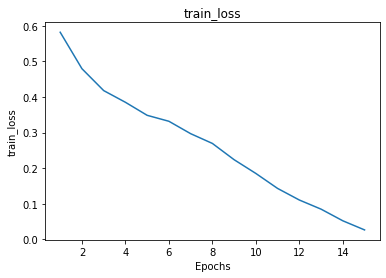

In [335]:
plot_loss(train_loss,"train_loss",15)

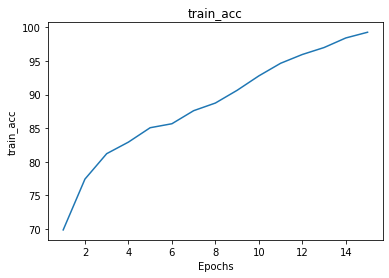

In [336]:
plot_loss(train_acc,"train_acc",15)

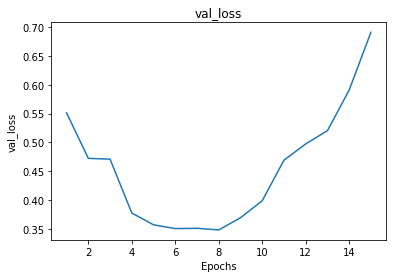

In [337]:
plot_loss(val_loss,"val_loss",15)

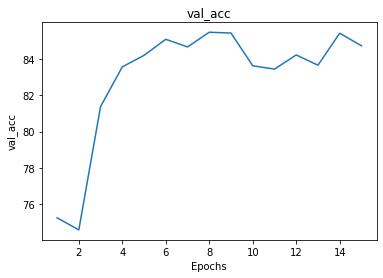

In [339]:
plot_loss(val_acc,"val_acc",15)